In [1]:
# Please set this to the parent folder of this file
setwd("~/Documents/statistical-data-processing-project/model/")


In [2]:
library(ggplot2)
library(tidyverse)
library(janitor)
library("e1071")
library(irr)
library(PRROC)
library(reshape2)
source("constants.R")


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ lubridate 1.9.4     ✔ tibble    3.2.1
✔ purrr     1.0.2     ✔ tidyr     1.3.1
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘janitor’


The following objects are masked from ‘package:stats’:

    chisq.test, fisher.test


Loading required package: lpSolve


Attaching package: ‘reshape2’


The following object is masked from ‘package:tidyr’:

    smiths




In [3]:
process_data <- function(data) {
  # Clean column names
  data <- clean_names(data)

  # Hàm để phân loại BMI
  categorize_bmi <- function(bmi) {
    if (bmi < 18.5) {
      return("Underweight")
    } else if (bmi >= 18.5 & bmi < 24.9) {
      return("Normal weight")
    } else if (bmi >= 25 & bmi < 29.9) {
      return("Overweight")
    } else if (bmi >= 30 & bmi < 34.9) {
      return("Obesity class 1")
    } else if (bmi >= 35 & bmi < 39.9) {
      return("Obesity class 2")
    } else {
      return("Obesity class 3")
    }
  }

  # Tạo cột mới bmi_category cho dataframe data
  data$bmi_category <- sapply(data$bmi, categorize_bmi)
  # Chuyển đổi bmi_category thành factor với các levels cụ thể
  data$bmi_category <- factor(data$bmi_category, levels = c("Underweight", "Normal weight", "Overweight", "Obesity class 1", "Obesity class 2", "Obesity class 3"))

  # Chuyển đổi các biến không định lượng thành factor
  quantitative_vars <- c("phys_hlth")

  non_quantitative_vars <- setdiff(names(data), quantitative_vars)
  data[non_quantitative_vars] <- lapply(data[non_quantitative_vars], factor)

  return(data)
}


In [4]:
train_test_split <- function(data, train_ratio = 0.8) {
  # Đặt seed để đảm bảo tính tái lập
  set.seed(SEED)
  train_indices <- sample(seq_len(nrow(data)), size = floor(train_ratio * nrow(data)), replace = FALSE)
  train_data <- data[train_indices, ]
  test_data <- data[-train_indices, ]
  res <- list(
    train_data = train_data,
    test_data = test_data
  )
  return(res)
}


In [5]:
bayes_cross_validate <- function(data, k = K) {
  # Đặt seed để đảm bảo tính tái lập
  set.seed(SEED)
  # Create k-folds
  folds <- sample(rep(1:k, length.out = nrow(data)))

  # Initialize a list to store results and models
  results <- list()
  models <- list()

  # Perform cross-validation
  for (i in 1:k) {
    # Split data into training and testing sets
    train_data <- data[folds != i, ]
    test_data <- data[folds == i, ]

    # Train the model on the training set
    model <- naiveBayes(formula = as.formula(paste(TARGET_COLUMN, "~ .")), data = train_data)

    # Predict on the testing set
    predictions <- predict(model, test_data)

    # Calculate metrics
    confusion <- table(predictions, test_data$diabetes_012)
    accuracy <- sum(diag(confusion)) / sum(confusion)
    precision <- diag(confusion) / rowSums(confusion)
    precision[is.nan(precision)] <- 0
    recall <- diag(confusion) / colSums(confusion)
    recall[is.nan(recall)] <- 0
    f1 <- 2 * (precision * recall) / (precision + recall)
    f1[is.nan(f1)] <- 0

    # Convert confusion matrix to data frame for kappam.fleiss
    confusion_df <- as.data.frame(as.table(confusion))
    kappa <- kappam.fleiss(confusion_df)$value

    # Store the result and model
    results[[i]] <- list(
      accuracy = accuracy,
      precision = precision,
      recall = recall,
      f1 = f1,
      kappa = kappa
    )
    models[[i]] <- model
  }

  return(list(models = models, results = results))
}


In [6]:
eval_multi_class <- function(x) {
  cc <- sum(diag(x))
  sc <- sum(x)
  pp <- colSums(x)
  tt <- rowSums(x)

  precision <- diag(x) / colSums(x)
  recall <- diag(x) / rowSums(x)
  macro_precision <- mean(precision)
  macro_recall <- mean(recall)
  macro_f1 <- 2 * macro_precision * macro_recall / (1 / macro_precision + 1 / macro_recall)
  accuracy <- cc / sc
  kappa <- (cc * sc - sum(pp * tt)) / (sc^2 - sum(pp * tt))
  return(list(
    Precision = precision, Recall = recall, Accuracy = accuracy, Kappa = kappa,
    Macro_F1 = macro_f1
  ))
}


In [7]:
evaluate_models <- function(train_data, test_data) {
  # Apply cross-validation on train_data for Naive Bayes
  bayes_results <- bayes_cross_validate(train_data)
  bayes_avg_results <- sapply(bayes_results$results, function(res) sapply(res, mean))

  # Combine results into a data frame
  avg_results <- data.frame(
    Metric = c("Accuracy", "Precision", "Recall", "F1", "Kappa"),
    bayes = bayes_avg_results
  )

  # Print the results as a table
  print(avg_results)

  # Train the bayes model on the entire training data
  final_bayes_model <- naiveBayes(formula = as.formula(paste(TARGET_COLUMN, "~ .")), data = train_data)

  # Predict on the test data using the model train on the full dataset
  bayes_predictions <- predict(final_bayes_model, test_data)

  # Get predicted probabilities
  bayes_pred_probs <- predict(final_bayes_model, test_data, type = "raw")

  # Create confusion matrix
  bayes_confusion <- table(test_data$diabetes_012, bayes_predictions)

  # Calculate metrics for bayes using eval_multi_class
  bayes_metrics <- eval_multi_class(bayes_confusion)

  # Create a data frame with the results
  results <- data.frame(
    Metric = c("Accuracy", "Precision", "Recall", "F1", "Kappa"),
    bayes = c(bayes_metrics$Accuracy, mean(bayes_metrics$Precision, na.rm = TRUE), mean(bayes_metrics$Recall, na.rm = TRUE), bayes_metrics$Macro_F1, bayes_metrics$Kappa)
  )

  # Plot the metrics
  metrics_data <- melt(results, id.vars = "Metric")

  ggplot(metrics_data, aes(x = Metric, y = value, fill = variable)) +
    geom_bar(stat = "identity", position = "dodge") +
    labs(
      title = "Performance Metrics for Naive Bayes Models",
      x = "Metric",
      y = "Value"
    ) +
    theme_minimal()

  # Return results, predicted probabilities, and predictions
  return(list(results = results, bayes_pred_probs = bayes_pred_probs, bayes_predictions = bayes_predictions))
}


In [8]:
plot_confusion_matrix <- function(conf_matrix, model_name) {
  conf_matrix_df <- as.data.frame(conf_matrix)
  colnames(conf_matrix_df) <- c("Actual", "Predicted", "Freq")

  ggplot(conf_matrix_df, aes(x = Actual, y = Predicted, fill = Freq)) +
    geom_tile() +
    geom_text(aes(label = Freq), color = "white") +
    scale_fill_gradient(low = "lightblue", high = "lightcoral") +
    labs(title = paste("Confusion Matrix -", model_name, "Predictions"), x = "Actual", y = "Predicted") +
    theme_minimal()
}


## Data Preprocessing

In [9]:
train_data <- read.csv("../data/train_data.csv")
test_data <- read.csv("../data/test_data.csv")


In [10]:
glimpse(train_data)


Rows: 202,944
Columns: 21
$ diabetes_012           <int> 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 2,…
$ high_bp                <int> 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1,…
$ high_chol              <int> 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1,…
$ chol_check             <int> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,…
$ smoker                 <int> 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1,…
$ stroke                 <int> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,…
$ heart_diseaseor_attack <int> 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,…
$ phys_activity          <int> 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1,…
$ fruits                 <int> 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0,…
$ veggies                <int> 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0,…
$ hvy_alcohol_consump    <int> 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,…
$ any_healthcare         <int> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,…
$ no_docbc_cos

In [11]:
train_data <- train_data |> mutate(across(everything(), as.factor))
test_data <- test_data |> mutate(across(everything(), as.factor))


In [12]:
glimpse(train_data)


Rows: 202,944
Columns: 21
$ diabetes_012           <fct> 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 2,…
$ high_bp                <fct> 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1,…
$ high_chol              <fct> 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1,…
$ chol_check             <fct> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,…
$ smoker                 <fct> 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1,…
$ stroke                 <fct> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,…
$ heart_diseaseor_attack <fct> 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,…
$ phys_activity          <fct> 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1,…
$ fruits                 <fct> 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0,…
$ veggies                <fct> 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0,…
$ hvy_alcohol_consump    <fct> 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,…
$ any_healthcare         <fct> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,…
$ no_docbc_cos

In [13]:
print(table(train_data$diabetes_012))
print(table(test_data$diabetes_012))



     0      1      2 
170989   3676  28279 

    0     1     2 
42714   955  7067 


## Modeling

### Work with the original dataset

In [14]:
results <- evaluate_models(train_data = train_data, test_data = test_data)


             Metric     bayes.1     bayes.2     bayes.3     bayes.4     bayes.5
accuracy   Accuracy  0.80041391  0.80263125  0.79947769  0.80442977  0.80159160
precision Precision  0.42554528  0.42642206  0.42517391  0.42922867  0.42666355
recall       Recall  0.46266013  0.46112030  0.46082689  0.46296950  0.46268832
f1               F1  0.43961807  0.43995031  0.43889156  0.44263582  0.44056891
kappa         Kappa -0.06930693 -0.06930693 -0.06930693 -0.06930693 -0.06930693


- Accuracy: Độ chính xác của mô hình ở mức chấp nhận được (khoảng 80%).
- Precision: Precision thấp cho thấy mức dương tính giả khá cao.
- Recall: Tỷ lệ nhận diện ra các lớp dương tính (1 và 2) không quá tốt (khoảng 46%)
- F1: Mô hình không quá tốt trong F1, chỉ khoảng 44%
- Kappa (Cohen's Kappa): Giá trị âm cho thấy mô hình không dự đoán tốt hơn quá nhiều so với dự đoán ngẫu nhiên

   
        0     1     2
  0 37085     0  5629
  1   611     0   344
  2  3471     0  3596

$Precision
        0         1         2 
0.9008429       NaN 0.3757968 

$Recall
        0         1         2 
0.8682165 0.0000000 0.5088439 

$Accuracy
[1] 0.8018173

$Kappa
[1] 0.3180812

$Macro_F1
[1] NaN

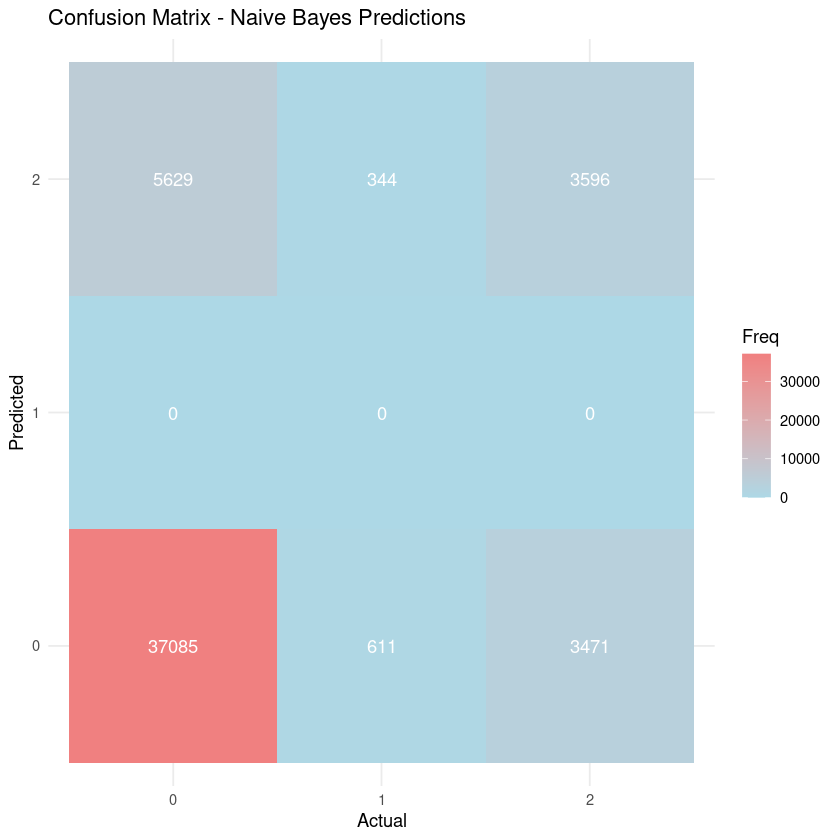

In [15]:
confusion_matrix <- table(test_data$diabetes_012, results$bayes_predictions)
confusion_matrix

eval_multi_class(confusion_matrix)

plot_confusion_matrix(conf_matrix = confusion_matrix, model_name = "Naive Bayes")


**ĐÁNH GIÁ VỀ SỰ PHÂN LOẠI**

Class 0 (Không bị tiểu đường):

- Được dự đoán là class 0: 37085 (True Negative).
- Sai khi dự đoán thành class 1 hoặc 2: 5629 mẫu, chỉ gồm class 2 → Mô hình cực kỳ ưu tiên class này.
- Nhận xét: Mô hình có độ chính xác cao với class 0 nhưng có thể bị overfitting vào class này do mất cân bằng dữ liệu rất nặng.

---
Class 1 (Tiền tiểu đường):

- Dự đoán đúng là class 1: 0 (True Positive).
- Sai thành class 0: 611 → Rất nhiều lỗi phân loại.
- Sai thành class 2: 344.
- Nhận xét: Mô hình có độ nhạy (Recall) rất thấp đối với class 1. Điều này cho thấy khả năng phát hiện class này của mô hình là rất kém.

---
Class 2 (Bị tiểu đường):

- Dự đoán đúng là class 2: 3596 (True Positive).
- Sai thành class 0: 3471 → Số lỗi phân loại đáng kể.
- Sai thành class 1: 0.
- Nhận xét: Hiệu suất dự đoán của mô hình đối với class 2 là khá tốt nhưng vẫn có tỷ lệ lỗi cao khi nhầm với class 0.

---

**ĐÁNH GIÁ TỔNG QUAN**

1. Sự thiên lệch nghiêm trọng về class (Imbalanced Data):
- Class 0 (Không bị tiểu đường) chiếm số lượng áp đảo.
- Mô hình hoạt động tốt trên class này nhưng lại bỏ qua các class khác (1 và 2).
2. Hiệu suất kém với class nhỏ (1 - Tiền tiểu đường):
- Mô hình không nhận diện được class này, cho thấy cần cải thiện bằng cách xử lý mất cân bằng dữ liệu.
3. Cần cải thiện độ nhạy (Recall) và độ chính xác cân bằng (Balanced Accuracy):
- Tập trung vào cải thiện các chỉ số F1-score và Precision cho các class thiểu số.

## Work with Oversampling data

In [16]:
oversampling_data <- read.csv("../data/oversampled_data.csv")
oversampling_data <- oversampling_data |> mutate(across(everything(), as.factor))

glimpse(oversampling_data)


Rows: 444,571
Columns: 21
$ diabetes_012           <fct> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,…
$ high_bp                <fct> 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0,…
$ high_chol              <fct> 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0,…
$ chol_check             <fct> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,…
$ smoker                 <fct> 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0,…
$ stroke                 <fct> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,…
$ heart_diseaseor_attack <fct> 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,…
$ phys_activity          <fct> 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,…
$ fruits                 <fct> 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1,…
$ veggies                <fct> 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1,…
$ hvy_alcohol_consump    <fct> 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,…
$ any_healthcare         <fct> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,…
$ no_docbc_cos

In [17]:
table(oversampling_data$diabetes_012)



     0      1      2 
170989 136791 136791 

In [18]:
oversampling_results <- evaluate_models(oversampling_data, test_data)


             Metric     bayes.1     bayes.2     bayes.3     bayes.4     bayes.5
accuracy   Accuracy  0.52688523  0.52820703  0.52676744  0.52683492  0.52612637
precision Precision  0.50278053  0.50242295  0.50132683  0.50281523  0.50199962
recall       Recall  0.51082439  0.51153451  0.51082519  0.51117553  0.51113429
f1               F1  0.49704249  0.49663628  0.49634382  0.49686176  0.49698266
kappa         Kappa -0.05882353 -0.05882353 -0.05882353 -0.05882353 -0.05882353


   
        0     1     2
  0 30606  5466  6642
  1   378   207   370
  2  1750  1374  3943

$Precision
        0         1         2 
0.9349911 0.0293742 0.3599270 

$Recall
        0         1         2 
0.7165332 0.2167539 0.5579454 

$Accuracy
[1] 0.6850363

$Kappa
[1] 0.2574037

$Macro_F1
[1] 0.1026042

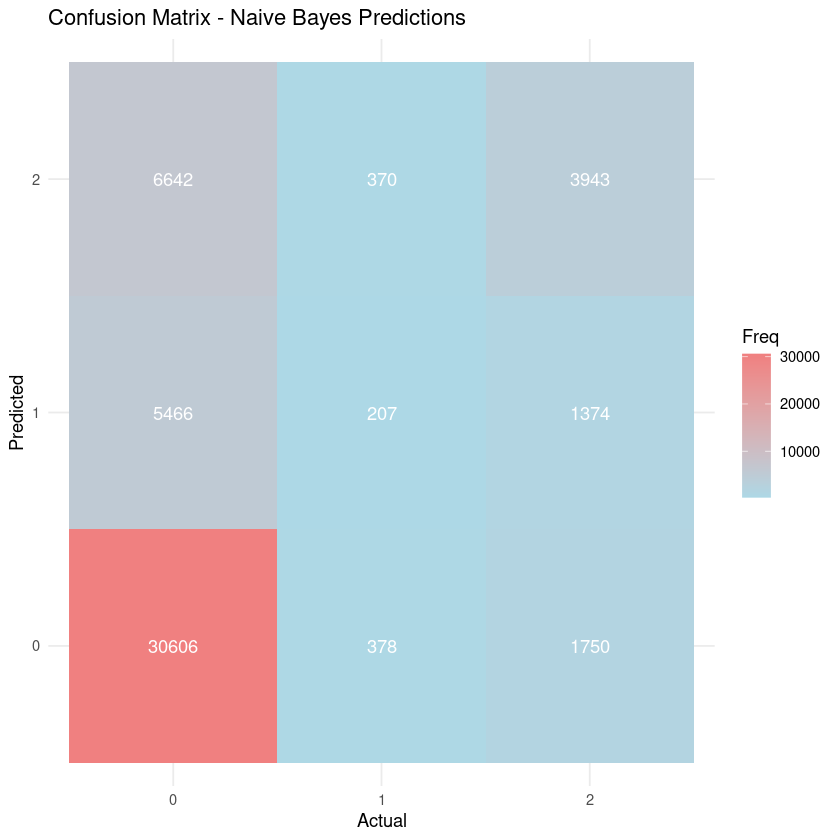

In [19]:
confusion_matrix <- table(test_data$diabetes_012, oversampling_results$bayes_predictions)
confusion_matrix

eval_multi_class(confusion_matrix)

plot_confusion_matrix(conf_matrix = confusion_matrix, model_name = "Naive Bayes")


#### Tăng Recall cho class 1 và class 2

In [20]:
calculate_optimal_thresholds <- function(probs, test_data) {
  # Tính PR Curve cho từng lớp (One-vs-Rest)
  pr_class0 <- pr.curve(scores.class0 = probs[, 1], weights.class0 = (test_data$diabetes_012 == 0), curve = TRUE)
  pr_class1 <- pr.curve(scores.class0 = probs[, 2], weights.class0 = (test_data$diabetes_012 == 1), curve = TRUE)
  pr_class2 <- pr.curve(scores.class0 = probs[, 3], weights.class0 = (test_data$diabetes_012 == 2), curve = TRUE)

  # Vẽ đồ thị Precision-Recall
  plot(pr_class0, col = "blue", main = "PR Curve - Class 0")
  plot(pr_class1, col = "red", add = TRUE)
  plot(pr_class2, col = "green", add = TRUE)
  legend("bottomleft", legend = c("Class 0", "Class 1", "Class 2"), col = c("blue", "red", "green"), lty = 1)

  # Tính F1-Score cho từng lớp
  precision0 <- pr_class0$curve[, 1]
  recall0 <- pr_class0$curve[, 2]
  f1_class0 <- 2 * (precision0 * recall0) / (precision0 + recall0)
  optimal_threshold0 <- pr_class0$curve[which.max(f1_class0), 3]

  precision1 <- pr_class1$curve[, 1]
  recall1 <- pr_class1$curve[, 2]
  f1_class1 <- 2 * (precision1 * recall1) / (precision1 + recall1)
  optimal_threshold1 <- pr_class1$curve[which.max(f1_class1), 3]

  precision2 <- pr_class2$curve[, 1]
  recall2 <- pr_class2$curve[, 2]
  f1_class2 <- 2 * (precision2 * recall2) / (precision2 + recall2)
  optimal_threshold2 <- pr_class2$curve[which.max(f1_class2), 3]

  # In ngưỡng tối ưu
  optimal_threshold0
  optimal_threshold1
  optimal_threshold2

  # Đặt ngưỡng tối ưu
  thresholds <- c(optimal_threshold0, optimal_threshold1, optimal_threshold2)

  # Điều chỉnh xác suất dự đoán
  adjusted_probs <- probs
  adjusted_probs[, 1] <- ifelse(probs[, 1] > thresholds[1], probs[, 1], 0)
  adjusted_probs[, 2] <- ifelse(probs[, 2] > thresholds[2], probs[, 2], 0)
  adjusted_probs[, 3] <- ifelse(probs[, 3] > thresholds[3], probs[, 3], 0)

  # Phân loại dựa trên xác suất cao nhất
  predicted_class <- apply(adjusted_probs, 1, which.max) - 1

  return(list(optimal_thresholds = thresholds, predicted_class = predicted_class))
}


In [21]:
bayes_probs <- oversampling_results$bayes_pred_probs


   predicted_class
        0     1     2
  0 33511  1298  7905
  1   461    78   416
  2  2382   345  4340

$Precision
         0          1          2 
0.92179678 0.04532249 0.34278493 

$Recall
         0          1          2 
0.78454371 0.08167539 0.61412198 

$Accuracy
[1] 0.7475757

$Kappa
[1] 0.301465

$Macro_F1
[1] 0.09982205

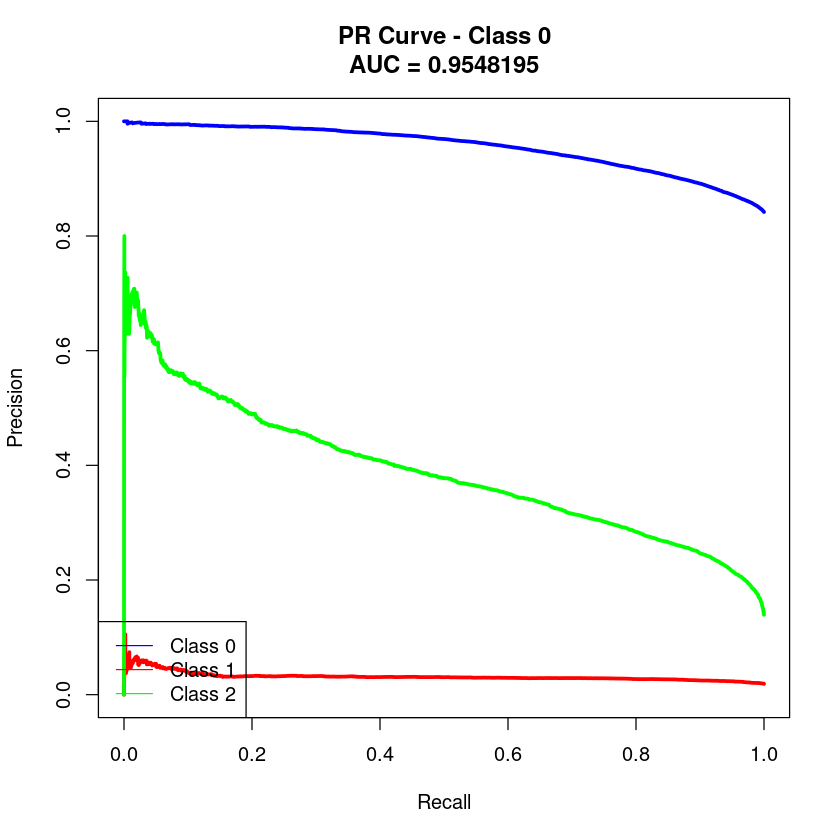

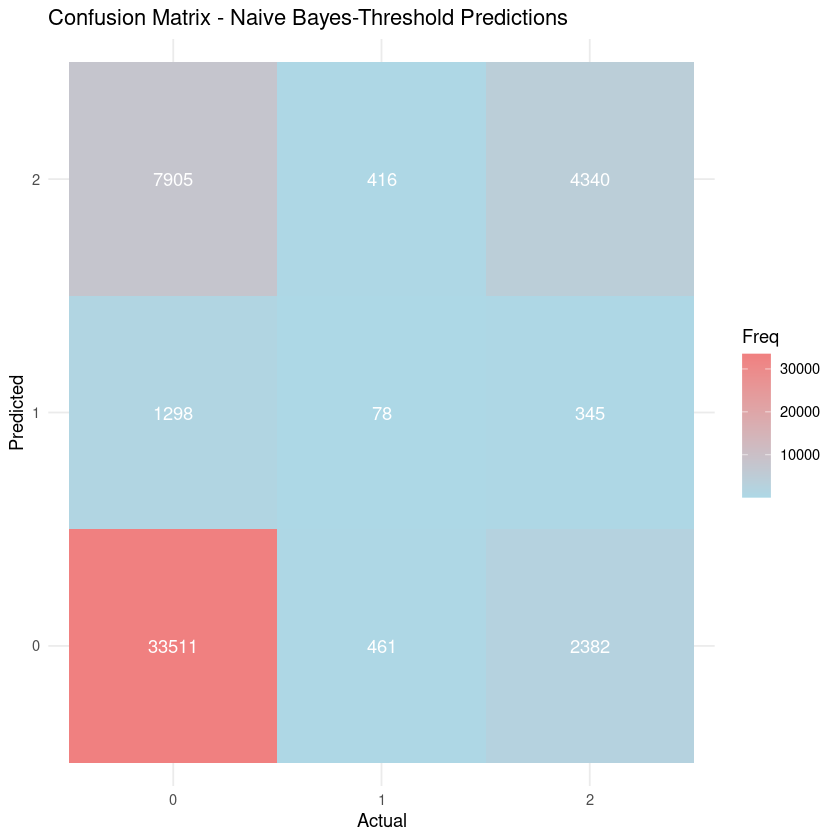

In [22]:
result <- calculate_optimal_thresholds(bayes_probs, test_data)
predicted_class <- result$predicted_class
optimal_thresholds <- result$optimal_thresholds

conf_matrix <- table(test_data$diabetes_012, predicted_class)
conf_matrix

eval_multi_class(conf_matrix)
# Plot confusion matrix using the function
plot_confusion_matrix(conf_matrix, "Naive Bayes-Threshold")


## Work with Undersampling data

In [23]:
undersampling_data <- read.csv("../data/undersampled_data.csv")
undersampling_data <- undersampling_data |> mutate(across(everything(), as.factor))

glimpse(undersampling_data)

table(undersampling_data$diabetes_012)


Rows: 11,028
Columns: 21
$ diabetes_012           <fct> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,…
$ high_bp                <fct> 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,…
$ high_chol              <fct> 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0,…
$ chol_check             <fct> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,…
$ smoker                 <fct> 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,…
$ stroke                 <fct> 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,…
$ heart_diseaseor_attack <fct> 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,…
$ phys_activity          <fct> 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,…
$ fruits                 <fct> 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0,…
$ veggies                <fct> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,…
$ hvy_alcohol_consump    <fct> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,…
$ any_healthcare         <fct> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,…
$ no_docbc_cost


   0    1    2 
3676 3676 3676 

In [24]:
undersampling_results <- evaluate_models(undersampling_data, test_data)


             Metric     bayes.1     bayes.2     bayes.3     bayes.4     bayes.5
accuracy   Accuracy  0.50997280  0.49274705  0.52719855  0.50839002  0.52471655
precision Precision  0.49798654  0.48142955  0.51645561  0.49291953  0.50899733
recall       Recall  0.50799771  0.49475432  0.53022691  0.50911635  0.52103691
f1               F1  0.49637613  0.47846266  0.51279798  0.49385866  0.51054660
kappa         Kappa -0.05882353 -0.05882353 -0.05882353 -0.05882353 -0.05882353


   
        0     1     2
  0 29204  6766  6744
  1   336   247   372
  2  1496  1619  3952

$Precision
         0          1          2 
0.94097177 0.02861446 0.35706541 

$Recall
        0         1         2 
0.6837103 0.2586387 0.5592189 

$Accuracy
[1] 0.6583688

$Kappa
[1] 0.2432011

$Macro_F1
[1] 0.1039338

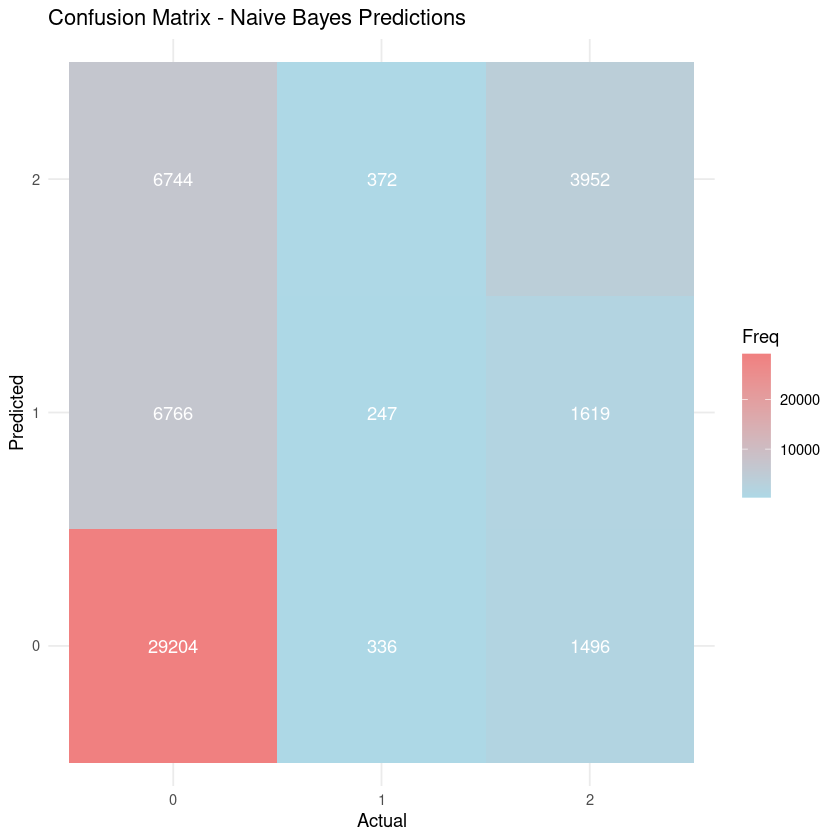

In [25]:
confusion_matrix <- table(test_data$diabetes_012, undersampling_results$bayes_predictions)
confusion_matrix

eval_multi_class(confusion_matrix)

plot_confusion_matrix(conf_matrix = confusion_matrix, model_name = "Naive Bayes")


   predicted_class
        0     1     2
  0 30690  5272  6752
  1   379   202   374
  2  1810  1285  3972

$Precision
         0          1          2 
0.93342255 0.02988608 0.35790232 

$Recall
        0         1         2 
0.7184998 0.2115183 0.5620490 

$Accuracy
[1] 0.6871649

$Kappa
[1] 0.2577115

$Macro_F1
[1] 0.1023233

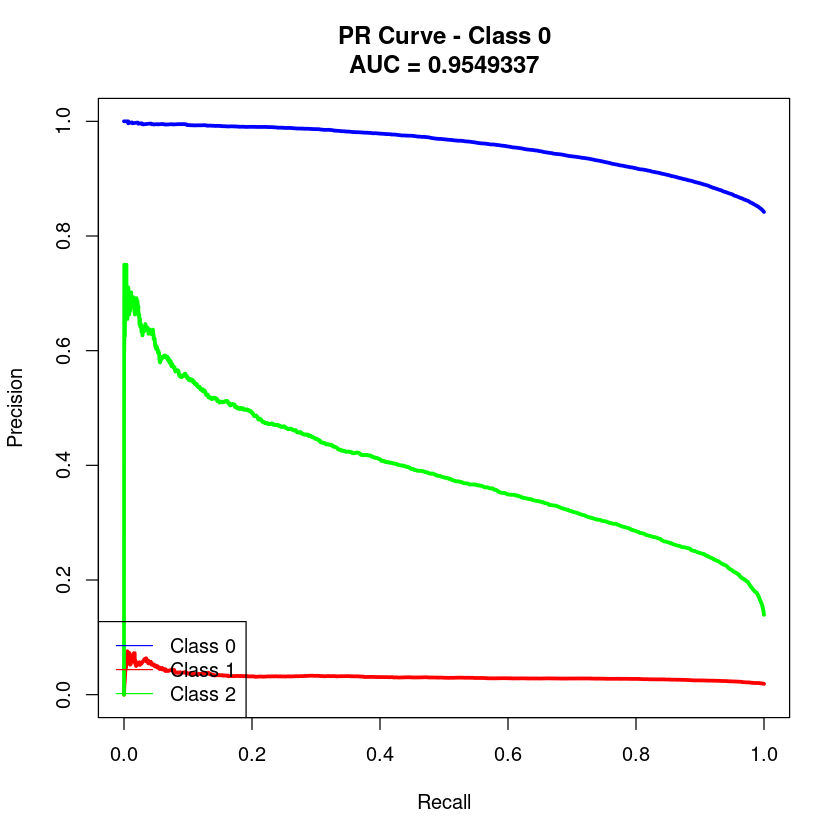

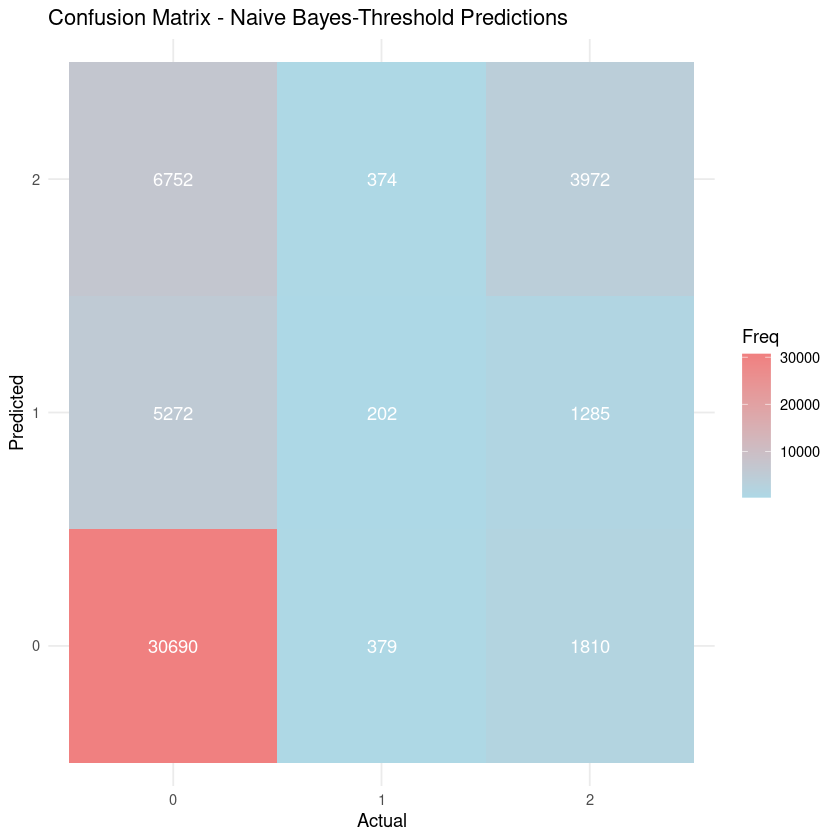

In [26]:
bayes_probs <- undersampling_results$bayes_pred_probs
result <- calculate_optimal_thresholds(bayes_probs, test_data)
predicted_class <- result$predicted_class
optimal_thresholds <- result$optimal_thresholds

conf_matrix <- table(test_data$diabetes_012, predicted_class)
conf_matrix

eval_multi_class(conf_matrix)
# Plot confusion matrix using the function
plot_confusion_matrix(conf_matrix, "Naive Bayes-Threshold")


## Work with SMOTE data

In [27]:
smote_data <- read.csv("../data/smote_augmented_data_80_percent.csv")
smote_data <- smote_data |> mutate(across(everything(), as.factor))

glimpse(smote_data)

table(smote_data$diabetes_012)


Rows: 444,571
Columns: 21
$ diabetes_012           <fct> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,…
$ high_bp                <fct> 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0,…
$ high_chol              <fct> 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0,…
$ chol_check             <fct> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,…
$ smoker                 <fct> 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0,…
$ stroke                 <fct> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,…
$ heart_diseaseor_attack <fct> 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,…
$ phys_activity          <fct> 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,…
$ fruits                 <fct> 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1,…
$ veggies                <fct> 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1,…
$ hvy_alcohol_consump    <fct> 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,…
$ any_healthcare         <fct> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,…
$ no_docbc_cos


     0      1      2 
170989 136791 136791 

In [28]:
smote_results <- evaluate_models(smote_data, test_data)


             Metric     bayes.1     bayes.2     bayes.3     bayes.4     bayes.5
accuracy   Accuracy  0.53932407  0.54060103  0.53841915  0.54160200  0.53732820
precision Precision  0.51793344  0.51806847  0.51618558  0.52000231  0.51663585
recall       Recall  0.52406552  0.52486052  0.52325455  0.52692724  0.52300870
f1               F1  0.51211457  0.51257162  0.51142699  0.51426967  0.51094078
kappa         Kappa -0.05882353 -0.05882353 -0.05882353 -0.05882353 -0.05882353


   
        0     1     2
  0 30767  5208  6739
  1   384   204   367
  2  1792  1341  3934

$Precision
        0         1         2 
0.9339465 0.0302088 0.3563406 

$Recall
        0         1         2 
0.7203025 0.2136126 0.5566719 

$Accuracy
[1] 0.687973

$Kappa
[1] 0.2580436

$Macro_F1
[1] 0.1020896

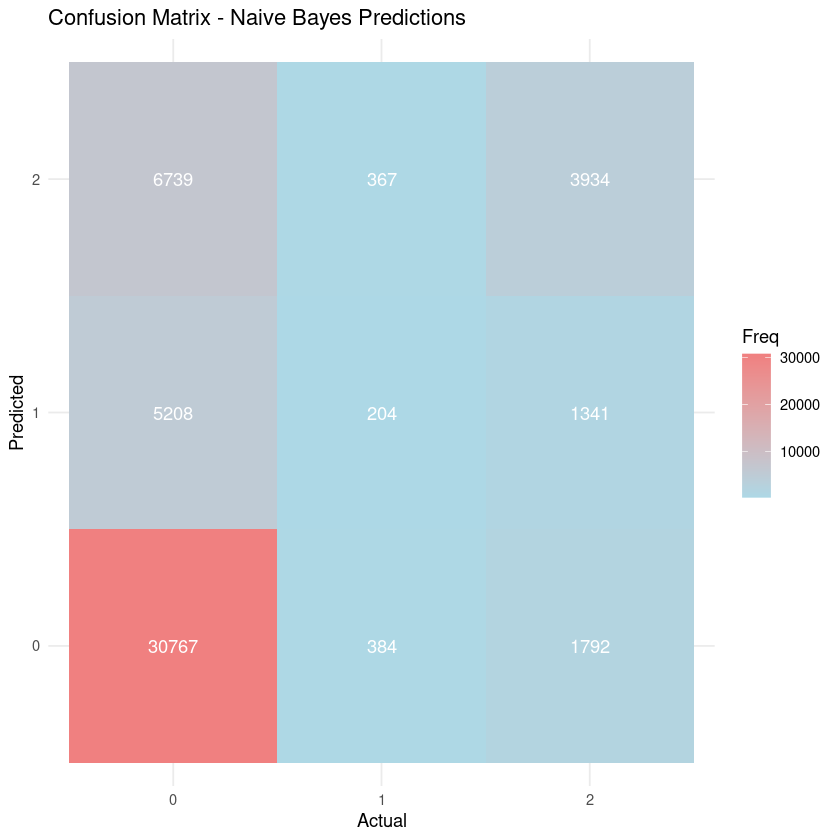

In [29]:
confusion_matrix <- table(test_data$diabetes_012, smote_results$bayes_predictions)
confusion_matrix

eval_multi_class(confusion_matrix)

plot_confusion_matrix(conf_matrix = confusion_matrix, model_name = "Naive Bayes")


   predicted_class
        0     1     2
  0 31406  4995  6313
  1   404   198   353
  2  1957  1284  3826

$Precision
         0          1          2 
0.93007966 0.03056971 0.36465879 

$Recall
        0         1         2 
0.7352624 0.2073298 0.5413896 

$Accuracy
[1] 0.6983207

$Kappa
[1] 0.261459

$Macro_F1
[1] 0.1019907

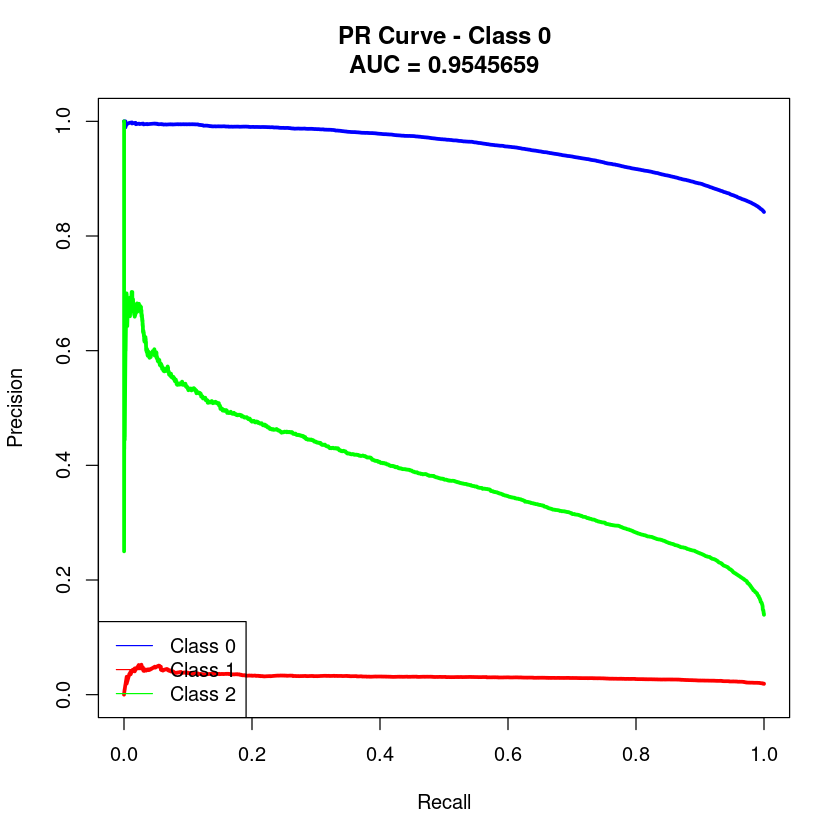

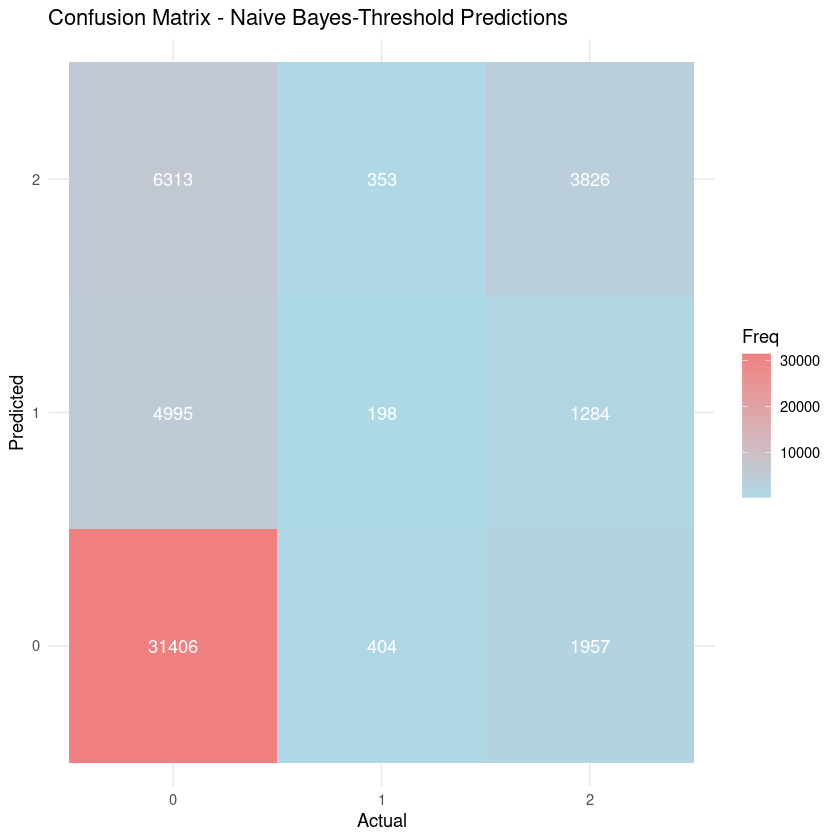

In [30]:
bayes_probs <- smote_results$bayes_pred_probs
result <- calculate_optimal_thresholds(bayes_probs, test_data)
predicted_class <- result$predicted_class
optimal_thresholds <- result$optimal_thresholds

conf_matrix <- table(test_data$diabetes_012, predicted_class)
conf_matrix

eval_multi_class(conf_matrix)
# Plot confusion matrix using the function
plot_confusion_matrix(conf_matrix, "Naive Bayes-Threshold")


## Modeling With Binary 0 & {1, 2}

In [31]:
convert_to_binary <- function(data) {
  data |> mutate(diabetes_012 = ifelse(diabetes_012 %in% c(1, 2), 1, ifelse(diabetes_012 == 0, 0, diabetes_012)))
}


binary_train_data <- convert_to_binary(train_data)
binary_oversampling_data <- convert_to_binary(oversampling_data)
binary_undersampling_data <- convert_to_binary(undersampling_data)
binary_smote_data <- convert_to_binary(smote_data)
binary_test_data <- convert_to_binary(test_data)


In [32]:
table(binary_train_data$diabetes_012)
table(binary_test_data$diabetes_012)



     0      1 
170989  31955 


    0     1 
42714  8022 

## Original Dataset

In [33]:
binary_results <- evaluate_models(binary_train_data, binary_test_data)


             Metric    bayes.1    bayes.2    bayes.3    bayes.4    bayes.5
accuracy   Accuracy  0.8033211  0.8053167  0.8029762  0.8069674  0.8046960
precision Precision  0.6538659  0.6547288  0.6541151  0.6587205  0.6560070
recall       Recall  0.6892225  0.6868958  0.6868452  0.6896818  0.6890945
f1               F1  0.6671732  0.6672195  0.6666961  0.6709508  0.6687636
kappa         Kappa -0.1111111 -0.1111111 -0.1111111 -0.1111111 -0.1111111


   
        0     1
  0 36787  5927
  1  3955  4067

$Precision
        0         1 
0.9029257 0.4069442 

$Recall
        0         1 
0.8612399 0.5069808 

$Accuracy
[1] 0.8052271

$Kappa
[1] 0.3347984

$Macro_F1
[1] 0.2998357

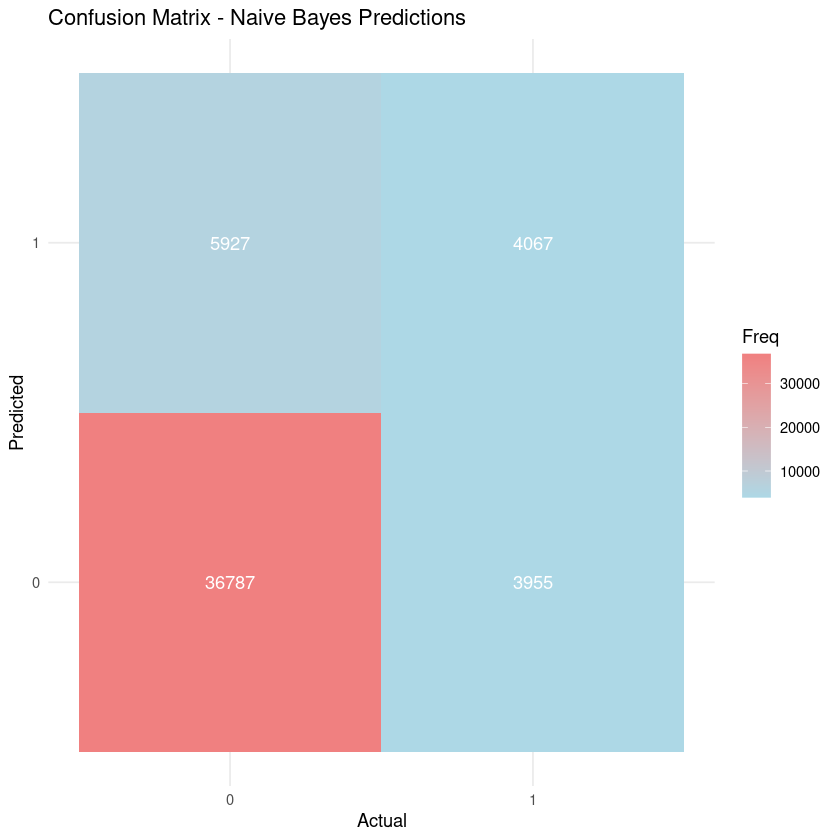

In [34]:
confusion_matrix <- table(binary_test_data$diabetes_012, binary_results$bayes_predictions)
confusion_matrix

eval_multi_class(confusion_matrix)

# Plot confusion matrix using the function
plot_confusion_matrix(confusion_matrix, "Naive Bayes")


## Oversampling data

In [35]:
oversampling_binary_results <- evaluate_models(binary_oversampling_data, binary_test_data)


             Metric    bayes.1    bayes.2    bayes.3    bayes.4    bayes.5
accuracy   Accuracy  0.7219029  0.7235981  0.7247678  0.7221360  0.7248577
precision Precision  0.7075311  0.7097045  0.7103625  0.7074924  0.7095042
recall       Recall  0.7107396  0.7128329  0.7136146  0.7114676  0.7130370
f1               F1  0.7089001  0.7110426  0.7117547  0.7091206  0.7110091
kappa         Kappa -0.1111111 -0.1111111 -0.1111111 -0.1111111 -0.1111111


   
        0     1
  0 28373 14341
  1  1641  6381

$Precision
        0         1 
0.9453255 0.3079336 

$Recall
        0         1 
0.6642553 0.7954375 

$Accuracy
[1] 0.6849968

$Kappa
[1] 0.279804

$Macro_F1
[1] 0.3083916

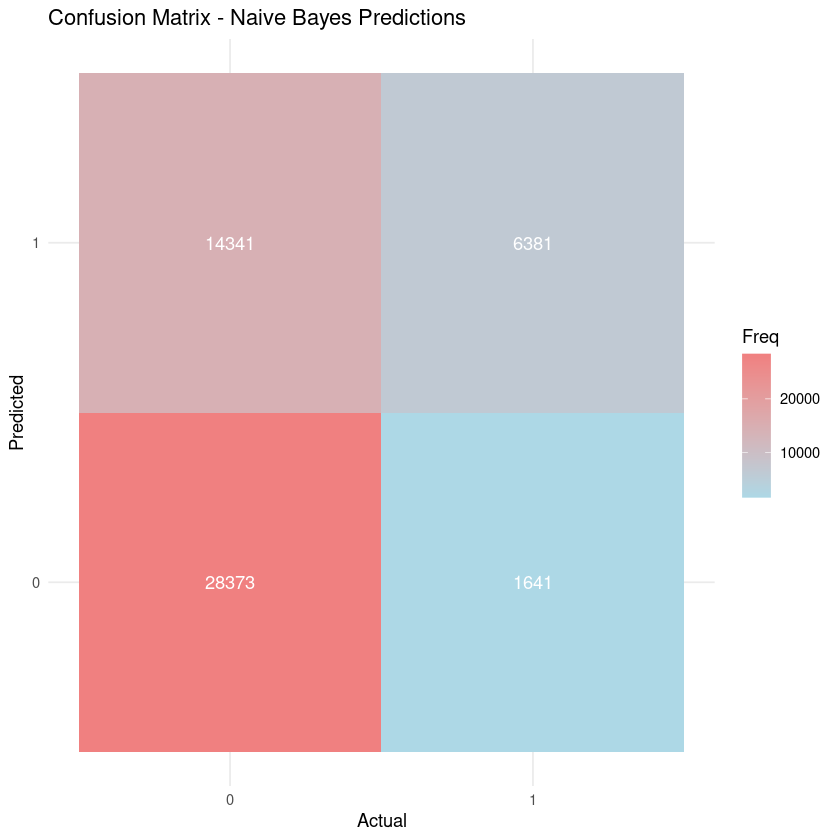

In [37]:
confusion_matrix <- table(binary_test_data$diabetes_012, oversampling_binary_results$bayes_predictions)
confusion_matrix

eval_multi_class(confusion_matrix)

# Plot confusion matrix using the function
plot_confusion_matrix(confusion_matrix, "Naive Bayes")


## Work with undersampling data

In [40]:
undersampling_binary_results <- evaluate_models(binary_undersampling_data, binary_test_data)


             Metric    bayes.1    bayes.2    bayes.3    bayes.4    bayes.5
accuracy   Accuracy  0.7348141  0.7348141  0.7452403  0.7446712  0.7451247
precision Precision  0.7056879  0.7008488  0.7176155  0.7128004  0.7133179
recall       Recall  0.7086257  0.7079426  0.7264253  0.7215087  0.7124430
f1               F1  0.7070615  0.7038802  0.7211823  0.7164171  0.7128736
kappa         Kappa -0.1111111 -0.1111111 -0.1111111 -0.1111111 -0.1111111


   
        0     1
  0 27058 15656
  1  1403  6619

$Precision
        0         1 
0.9507045 0.2971493 

$Recall
        0         1 
0.6334691 0.8251060 

$Accuracy
[1] 0.6637693

$Kappa
[1] 0.2663769

$Macro_F1
[1] 0.3060049

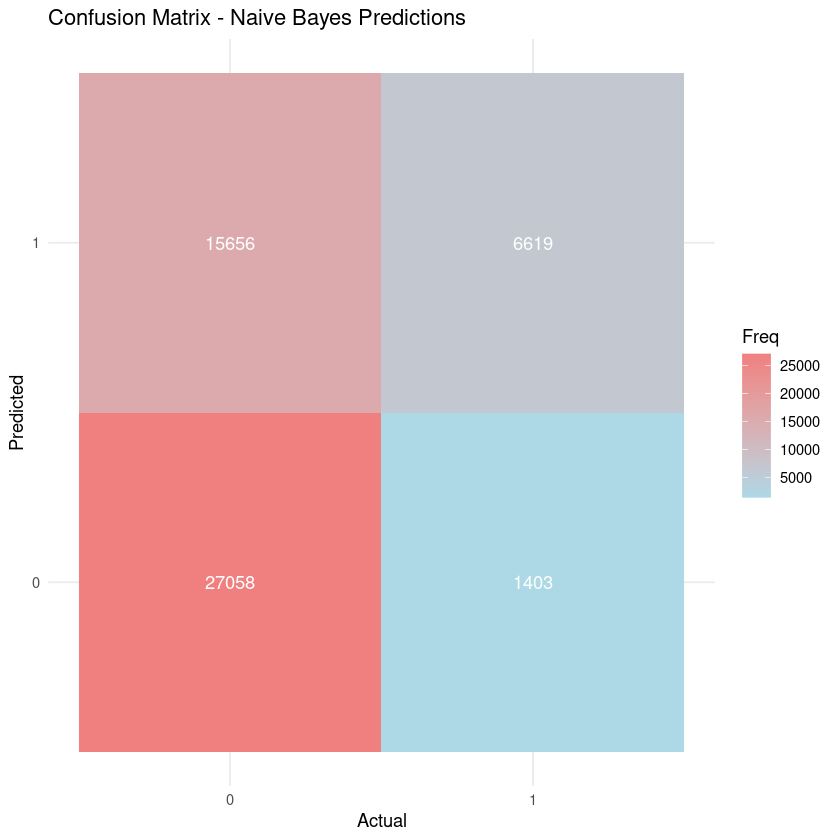

In [41]:
confusion_matrix <- table(binary_test_data$diabetes_012, undersampling_binary_results$bayes_predictions)
confusion_matrix

eval_multi_class(confusion_matrix)

# Plot confusion matrix using the function
plot_confusion_matrix(confusion_matrix, "Naive Bayes")


## Work with SMOTE data

In [38]:
smote_binary_results <- evaluate_models(binary_smote_data, binary_test_data)


             Metric    bayes.1    bayes.2    bayes.3    bayes.4    bayes.5
accuracy   Accuracy  0.7342631  0.7376116  0.7365319  0.7381627  0.7359808
precision Precision  0.7199566  0.7237685  0.7221785  0.7234576  0.7206824
recall       Recall  0.7218794  0.7251286  0.7240595  0.7253916  0.7229607
f1               F1  0.7208462  0.7244134  0.7230523  0.7243567  0.7217275
kappa         Kappa -0.1111111 -0.1111111 -0.1111111 -0.1111111 -0.1111111


   
        0     1
  0 28584 14130
  1  1689  6333

$Precision
        0         1 
0.9442077 0.3094854 

$Recall
        0         1 
0.6691951 0.7894540 

$Accuracy
[1] 0.6882096

$Kappa
[1] 0.2814146

$Macro_F1
[1] 0.3082334

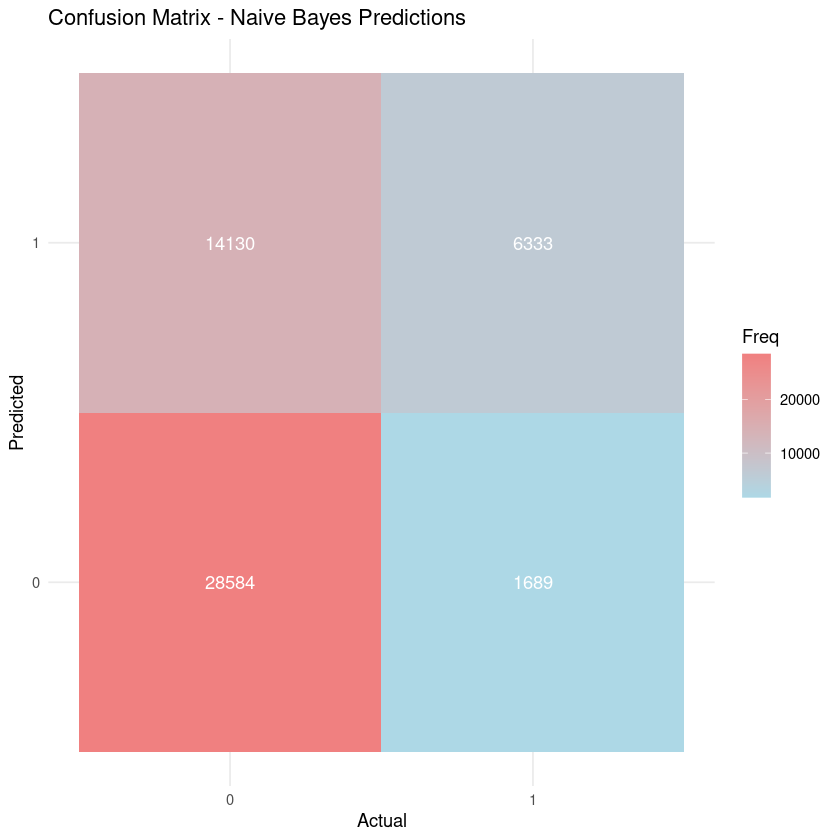

In [39]:
confusion_matrix <- table(binary_test_data$diabetes_012, smote_binary_results$bayes_predictions)
confusion_matrix

eval_multi_class(confusion_matrix)

# Plot confusion matrix using the function
plot_confusion_matrix(confusion_matrix, "Naive Bayes")
